In [1]:
import pandas as pd
import strategy
import matplotlib.pyplot as plt

In [2]:
def backtest(df_skew):
    position = 0
    cash = 0
    last_price = None
    results = []

    for i, row in df_skew.iterrows():
        midprice = row['midprice']
        skew = row['error_zscore']
        if abs(skew - 1) >= 0.0005:  # trigger a trade if skew factor changed at least 5bp
            trade_size = 1  # for simplicity, always trade size of 1
            if skew > 1:  # buy
                cash -= midprice * trade_size
                position += trade_size
            else:  # sell
                cash += midprice * trade_size
                position -= trade_size
        result = {
            'time': i,
            'cash': cash,
            'position': position,
            'midprice': midprice,
            'skew': skew,
            'value': cash + position * midprice,
        }
        if last_price is not None:
            result['return'] = (result['value'] - last_price) / last_price
        results.append(result)
        last_price = result['value']

    return pd.DataFrame(results).set_index('time')


In [3]:
def compute_metrics(df):
    net_profit = df['cash'].iloc[-1] - df['cash'].iloc[0]
    gross_profit = df[df['cash'] > 0]['cash'].sum()
    gross_loss = df[df['cash'] < 0]['cash'].sum()
    profit_factor = gross_profit / abs(gross_loss)
    max_drawdown = df['cash'].cummax() - df['cash']
    sharpe_ratio = df['return'].mean() / df['return'].std()
    total_trades = len(df)
    profitable_trades = len(df[df['return'] > 0])
    percent_profitable = profitable_trades / total_trades * 100
    avg_trade_profit = net_profit / total_trades
    largest_winning_trade = df[df['return'] > 0]['return'].max()
    largest_losing_trade = df[df['return'] < 0]['return'].min()
    
    print(f"Net Profit: {net_profit}")
    print(f"Gross Profit: {gross_profit}")
    print(f"Gross Loss: {gross_loss}")
    print(f"Profit Factor: {profit_factor}")
    print(f"Max Drawdown: {max_drawdown.max()}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    print(f"Total Number of Trades: {total_trades}")
    print(f"Percentage of Profitable Trades: {percent_profitable}%")
    print(f"Average Trade Profit: {avg_trade_profit}")
    print(f"Largest Winning Trade: {largest_winning_trade}")
    print(f"Largest Losing Trade: {largest_losing_trade}")

In [4]:

df_public, skew = strategy.compute_strat_skew('SOL/USDT', 20)
df_backtest = backtest(df_public)

df_backtest


Current Kalman strategy skew factor: 0.999143679772909


C:\Users\esteb\AppData\Local\Temp\ipykernel_14524\2343656355.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  result['return'] = (result['value'] - last_price) / last_price


,cash,position,midprice,skew,value,return
time,,,,,,
2023-05-23 00:32:00,19.5785,-1,19.5785,-0.085528,0.0000,NaN
2023-05-23 00:33:00,39.1605,-2,19.5820,0.374873,-0.0035,-inf
2023-05-23 00:34:00,58.7400,-3,19.5795,0.142327,0.0015,-1.428571
2023-05-23 00:35:00,78.3280,-4,19.5880,0.313030,-0.0240,-17.000000
2023-05-23 00:36:00,97.9210,-5,19.5930,0.254629,-0.0440,0.833333
...,...,...,...,...,...,...
2023-05-23 10:07:00,4971.6980,-251,19.7905,-0.530882,4.2825,0.356295
2023-05-23 10:08:00,4991.4860,-252,19.7880,-0.694366,4.9100,0.146527
2023-05-23 10:09:00,5011.2760,-253,19.7900,-0.112831,4.4060,-0.102648


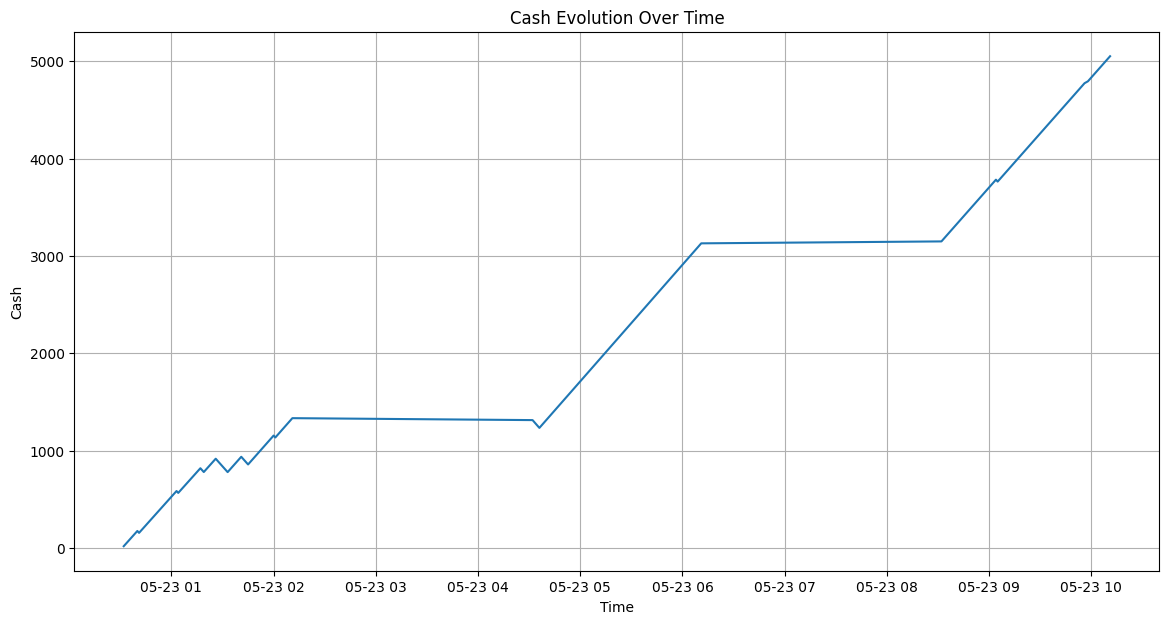

Net Profit: 5031.2874999999985
Gross Profit: 691822.1879999997
Gross Loss: 0.0
Profit Factor: inf
Max Drawdown: 137.61799999999994
Sharpe Ratio: nan
Total Number of Trades: 299
Percentage of Profitable Trades: 47.82608695652174%
Average Trade Profit: 16.827048494983273
Largest Winning Trade: 61.625000000602185
Largest Losing Trade: -inf


C:\Users\esteb\AppData\Local\Temp\ipykernel_14524\2405316298.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  profit_factor = gross_profit / abs(gross_loss)


In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df_backtest.index, df_backtest['cash'])
plt.title('Cash Evolution Over Time')
plt.xlabel('Time')
plt.ylabel('Cash')
plt.grid(True)
plt.show() 

compute_metrics(df_backtest)